# Notebook for detecting balls and training the linear regression model

In [1]:
from ultralytics import YOLO
import cv2
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


## 1. Ball-detection Function
Uses a yolo model to detect objects in an image.
If needed, the images can be shown on screen with their annotations.
Returns a dictionary of the images with their corresponding detection results

In [2]:
def detect_tennisballs(model, general_path, show_images):
    folder_path = general_path + "/images"
    csv_path = general_path + "/distance_labels/annotations.csv"
    df = pd.read_csv(csv_path)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    results_dict = {}

    for image in image_files:
        image_path = os.path.join(folder_path, image)
        results = model(image_path, verbose=False)
        results_dict[image] = results
        annotated_frame = results[0].plot()

        if show_images:
            row = df[df['ImageName'] == image]
            if not row.empty:
                distance = row.iloc[0]['Distance']
                text = f"Abstand: {distance:.2f} m"
                cv2.putText(annotated_frame, text, (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

            while True:
                cv2.imshow('Object Detection', annotated_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            cv2.destroyAllWindows()
            
    return(results_dict)

## 2. Auswertungsfunktion
Prüft, auf welchen Bildern eines input dictionaries Objekte der Klasse Sports Balls vorhanden sind.\
Teilt die Bilder in Gruppen ein, je nachdem, ob ein Ball erkannt wurde, kein Ball erkannt wurde oder fälschlicherweise ein anderes Objekt erkannt wurde.\
Gitb eine schriftliche Statistische Auswertung dieser Gruppen aus, sowie ein Histogramm der Gruppen je nach Distanzen.

In [3]:
def auswertung_mit_statistik(results_dict, csv_path):
    statistik = []
    fehler_distanzen = []
    erkannt_distanzen = []
    keine_erkennung_distanzen = []
    df = pd.read_csv(csv_path)

    for image, results in results_dict.items():
        boxes = results[0].boxes
        detected_classes = boxes.cls.tolist() if boxes is not None else []
        sportsball_erkannt = 32 in detected_classes
        andere_objekte = [cls for cls in detected_classes if cls != 32]
        nichts_erkannt = len(detected_classes) == 0

        row = df[df['ImageName'] == image]
        distance = row.iloc[0]['Distance'] if not row.empty else None
        
        statistik.append({
            "Image": image,
            "Distance": distance,
            "Sportsball erkannt": sportsball_erkannt,
            "Andere Objekte erkannt": bool(andere_objekte),
            "Nichts erkannt": nichts_erkannt,
            "Boundingbox": boxes if sportsball_erkannt else None
        })

        if distance is not None:
            if sportsball_erkannt:
                erkannt_distanzen.append(distance)
            elif nichts_erkannt:
                keine_erkennung_distanzen.append(distance)
            else:
                fehler_distanzen.append(distance)

    df_stat = pd.DataFrame(statistik)

    print("\n--- Statistische Auswertung ---")
    print("Gesamtbilder:", len(df_stat))
    print("Sportsball erkannt:", df_stat['Sportsball erkannt'].sum())
    print("Fehlerkennungen (andere Objekte):", df_stat['Andere Objekte erkannt'].sum())
    print("Keine Erkennung:", df_stat['Nichts erkannt'].sum())

    plt.hist([erkannt_distanzen, fehler_distanzen, keine_erkennung_distanzen],
             bins=10,
             label=['Richtig erkannt', 'Falsch erkannt', 'Nicht erkannt'],
             color=['green', 'orange', 'red'],
             stacked=True)
    plt.xlabel('Distanz (m)')
    plt.ylabel('Anzahl Bilder')
    plt.legend()
    plt.title('Erkennung vs. Distanz')
    plt.show()
    return df_stat

## 3. Ausführung der Funktionen

In [4]:
model = YOLO('yolov8n.pt')

date = "2025-07-01_23-12-36_zweitausend"
general_path = "C:/Users/Lenovo/TennisCourt/TennisCourt/Assets/Screenshots/" + date
csv_path = general_path + "/distance_labels/annotations.csv"

# Lädt bereits vorhandene Detection results, um Zeit zu sparen, wenn diese existieren.
# Wenn keine existieren, wird die detection function aufgerufen.
filename = f'detection_results.pkl'
if os.path.exists(filename):
    with open(filename, 'rb') as f:
        detections_results = pickle.load(f)
else:
    detections_results = detect_tennisballs(model, general_path, show_images=False)
    with open(filename, 'wb') as f:
        pickle.dump(detections_results, f)

## 4. Auswertung der detections


--- Statistische Auswertung ---
Gesamtbilder: 2000
Sportsball erkannt: 1931
Fehlerkennungen (andere Objekte): 298
Keine Erkennung: 3


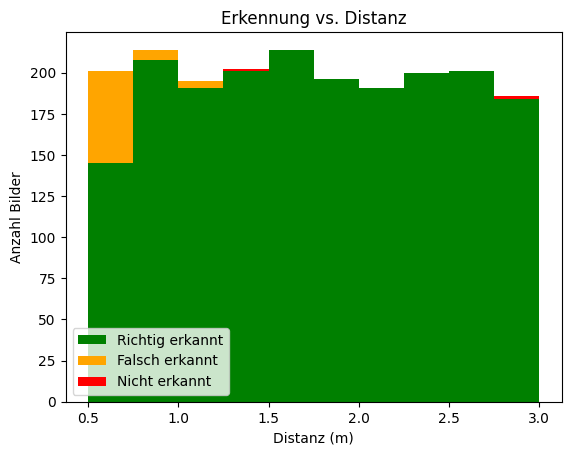

In [5]:
df_stat = auswertung_mit_statistik(detections_results, csv_path)

## 6. Weitere EDA und Feature Engineering für das Regressionsmodell

In [6]:
df_stat.head()

,Image,Distance,Sportsball erkannt,Andere Objekte erkannt,Nichts erkannt,Boundingbox
0,2025-07-01_23-12-36_Screenshot_0.png,1.147651,True,False,False,(((ultralytics.engine.results.Boxes object wit...
1,2025-07-01_23-12-36_Screenshot_1.png,2.722906,True,False,False,(((ultralytics.engine.results.Boxes object wit...
2,2025-07-01_23-12-36_Screenshot_10.png,1.495645,True,False,False,(((ultralytics.engine.results.Boxes object wit...
3,2025-07-01_23-12-36_Screenshot_100.png,0.868309,True,True,False,(((ultralytics.engine.results.Boxes object wit...
4,2025-07-01_23-12-36_Screenshot_1000.png,2.678846,True,False,False,(((ultralytics.engine.results.Boxes object wit...


In [7]:
df_stat.shape    

(2000, 6)

### 6.1 Nur die Einträge, bei denen etwas erkannt wurde und eine korrekte Erkennung stattgefunden hat behalten.

In [8]:
df_only_annotated = df_stat[df_stat["Nichts erkannt"] != True]
df_only_correctly_annotated = df_only_annotated[df_only_annotated["Andere Objekte erkannt"] != True]
print(df_only_correctly_annotated)

                                        Image  ...                                        Boundingbox
0        2025-07-01_23-12-36_Screenshot_0.png  ...  (((ultralytics.engine.results.Boxes object wit...
1        2025-07-01_23-12-36_Screenshot_1.png  ...  (((ultralytics.engine.results.Boxes object wit...
2       2025-07-01_23-12-36_Screenshot_10.png  ...  (((ultralytics.engine.results.Boxes object wit...
4     2025-07-01_23-12-36_Screenshot_1000.png  ...  (((ultralytics.engine.results.Boxes object wit...
6     2025-07-01_23-12-36_Screenshot_1002.png  ...  (((ultralytics.engine.results.Boxes object wit...
...                                       ...  ...                                                ...
1993   2025-07-01_23-12-36_Screenshot_993.png  ...  (((ultralytics.engine.results.Boxes object wit...
1994   2025-07-01_23-12-36_Screenshot_994.png  ...  (((ultralytics.engine.results.Boxes object wit...
1996   2025-07-01_23-12-36_Screenshot_996.png  ...  (((ultralytics.engine.results.

In [9]:
df_only_correctly_annotated.shape

(1699, 6)

### 6.2 Nur die Bild Distanz und Boundingbox spalten, weil die Status ab hier irrelevant sind.

In [10]:
df_correctly_annotated_relevant_features = df_only_correctly_annotated[["Image", "Distance", "Boundingbox"]]
df_correctly_annotated_relevant_features.head()

,Image,Distance,Boundingbox
0,2025-07-01_23-12-36_Screenshot_0.png,1.147651,(((ultralytics.engine.results.Boxes object wit...
1,2025-07-01_23-12-36_Screenshot_1.png,2.722906,(((ultralytics.engine.results.Boxes object wit...
2,2025-07-01_23-12-36_Screenshot_10.png,1.495645,(((ultralytics.engine.results.Boxes object wit...
4,2025-07-01_23-12-36_Screenshot_1000.png,2.678846,(((ultralytics.engine.results.Boxes object wit...
6,2025-07-01_23-12-36_Screenshot_1002.png,2.802680,(((ultralytics.engine.results.Boxes object wit...


### 6.3 Ersten Eintrag der Boundingbox aus der ersten Zeile herausziehen, als Test, um die Formatierung eines Box Objektes zu verstehen.

In [11]:
first_boundingbox = df_correctly_annotated_relevant_features.iloc[0]['Boundingbox']
print(first_boundingbox)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([32.])
conf: tensor([0.4636])
data: tensor([[305.4268, 291.9456, 334.6945, 320.6019,   0.4636,  32.0000]])
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([1, 6])
xywh: tensor([[320.0606, 306.2737,  29.2677,  28.6562]])
xywhn: tensor([[0.5001, 0.4786, 0.0457, 0.0448]])
xyxy: tensor([[305.4268, 291.9456, 334.6945, 320.6019]])
xyxyn: tensor([[0.4772, 0.4562, 0.5230, 0.5009]])


### 6.4 xyxy Koordinaten aus den Boxes Objekten extrahieren.

In [12]:
def extract_xyxy_coordinates(boxes):
    if boxes is not None:
        return boxes.xyxy[0].tolist()
    else:
        return None
    
df_correctly_annotated_relevant_features['xyxy_coordinates'] = df_correctly_annotated_relevant_features['Boundingbox'].apply(extract_xyxy_coordinates)

df_correctly_annotated_relevant_features.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28512\838082927.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correctly_annotated_relevant_features['xyxy_coordinates'] = df_correctly_annotated_relevant_features['Boundingbox'].apply(extract_xyxy_coordinates)


,Image,Distance,Boundingbox,xyxy_coordinates
0,2025-07-01_23-12-36_Screenshot_0.png,1.147651,(((ultralytics.engine.results.Boxes object wit...,"[305.4267883300781, 291.94561767578125, 334.69..."
1,2025-07-01_23-12-36_Screenshot_1.png,2.722906,(((ultralytics.engine.results.Boxes object wit...,"[314.353515625, 259.4291687011719, 325.3599853..."
2,2025-07-01_23-12-36_Screenshot_10.png,1.495645,(((ultralytics.engine.results.Boxes object wit...,"[309.5406494140625, 278.0224609375, 330.881347..."
4,2025-07-01_23-12-36_Screenshot_1000.png,2.678846,(((ultralytics.engine.results.Boxes object wit...,"[313.802001953125, 259.7805480957031, 325.4714..."
6,2025-07-01_23-12-36_Screenshot_1002.png,2.802680,(((ultralytics.engine.results.Boxes object wit...,"[314.064208984375, 258.95172119140625, 326.098..."


### 6.5 Koordinaten aus der Liste als eigenen Features ergänzen und dann nur Distanzen und Koordinatenfeatures behalten.

In [13]:
df_distance_xy = df_correctly_annotated_relevant_features[["Distance", "xyxy_coordinates"]]

df_distance_xy[['upperleft_x', 'upperleft_y', 'lowerright_x', 'lowerright_y']] = pd.DataFrame(df_distance_xy['xyxy_coordinates'].tolist(), index=df_distance_xy.index)
df_distance_xy = df_distance_xy[["Distance", "upperleft_x", "upperleft_y", "lowerright_x", "lowerright_y"]]

df_distance_xy.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28512\748500186.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distance_xy[['upperleft_x', 'upperleft_y', 'lowerright_x', 'lowerright_y']] = pd.DataFrame(df_distance_xy['xyxy_coordinates'].tolist(), index=df_distance_xy.index)


,Distance,upperleft_x,upperleft_y,lowerright_x,lowerright_y
0,1.147651,305.426788,291.945618,334.694489,320.601868
1,2.722906,314.353516,259.429169,325.359985,269.738068
2,1.495645,309.540649,278.022461,330.881348,300.116943
4,2.678846,313.802002,259.780548,325.471436,270.652802
6,2.802680,314.064209,258.951721,326.098328,269.164612


### 6.6 Data und Target isolieren

In [14]:
X = df_distance_xy[["upperleft_x", "upperleft_y", "lowerright_x", "lowerright_y"]]
y = df_distance_xy[["Distance"]]

print(X.shape, y.shape)


(1699, 4) (1699, 1)


### 6.7 Train/Test-Split von 80/20 durchführen

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
X_train.shape, y_train.shape

((1359, 4), (1359, 1))

In [17]:
X_test.shape, y_test.shape

((340, 4), (340, 1))

## 7. Modelltraining

In [18]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_prediction = model.predict(X_test)

## 8. Modellevaluation

In [19]:
mse = mean_squared_error(y_test, y_prediction)
print('Feature Names:', "upperleft_x", "upperleft_y", "lowerright_x", "lowerright_y")
print('Coefficients:', model.coef_) 
print('Mean squared error (MSE):', mse) 
print("Root mean squared error (RMSE):", np.sqrt(mse))  
print('Coefficient of determination (R2):', r2_score(y_test, y_prediction))

Feature Names: upperleft_x upperleft_y lowerright_x lowerright_y
Coefficients: [[ -0.0027227    0.078482    -0.15628   -0.046599]]
Mean squared error (MSE): 0.07021998746523553
Root mean squared error (RMSE): 0.26499054221846396
Coefficient of determination (R2): 0.8263892661929303


Der Meansquared error ist sehr gering, je geringer desto besser.\
Im Durchschnitt weichen die Vorhersagen nur um 0.28 m (RSME) vom tatsächlichen Wert ab.\
Das Modell erklärt die Streuung der Daten relativ zuverlässig (R2).

### 8.1 Learning Curve plotten

In [20]:
def plot_learningCurveDisplay(mlmodel, X_input, y_input): 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    common_params = {
        "X": X_input,
        "y": y_input,
        "train_sizes": np.linspace(0.1, 1.0, 10),
        "cv": ShuffleSplit(n_splits=100, test_size=0.2, random_state=2), 
        "score_type": "both",
        "n_jobs": 4,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
        "score_name": "MSE",
    }
    LearningCurveDisplay.from_estimator(mlmodel, **common_params, ax=ax, scoring=make_scorer(mean_squared_error))
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Training Score", "Test Score"])
    ax.set_title(f"Learning Curve for {mlmodel.__class__.__name__}")
    plt.show()

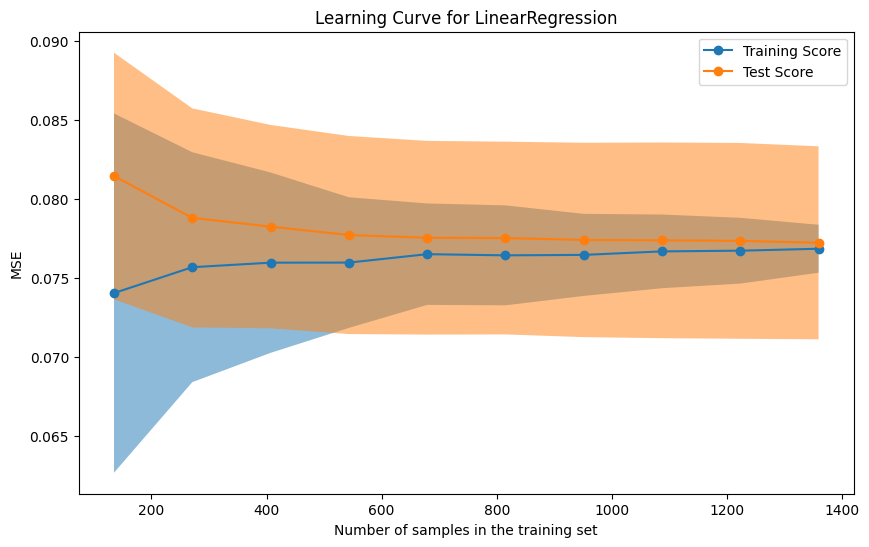

In [21]:
plot_learningCurveDisplay(model, X, y)

- Der MSE ist bereits von Anfang an sehr gering, höchstwahrscheinlich weil es sich bei disem Problem um ein Problem mit sehr linearer Beziehung handelt, das einfach durch lineare Regression gelöst werden kann.\
Die Beziehung ist Bounding Box Größe zu Entfernung.\
- Mehr Trainingsdaten verbessern die Testleistung nur geringfügig. Beide Datensätze konvergieren (nähern sich zueinander an) nach relativ kurzer Zeit nur noch sehr langsam.\
- Dennoch konvergieren sie, es bestehen also keine großen Unterschiede zwischen Training und Test, was darauf hindeutet, dass das Model zumindest nicht auf die Trainingsdaten Overfitted wurde.\
- Da Die Fehler beider Datensätze insgesamt sehr niedrig sind, und konvergieren, kann man davon ausgehen, dass das model relativ zuverlässig arbeitet. 

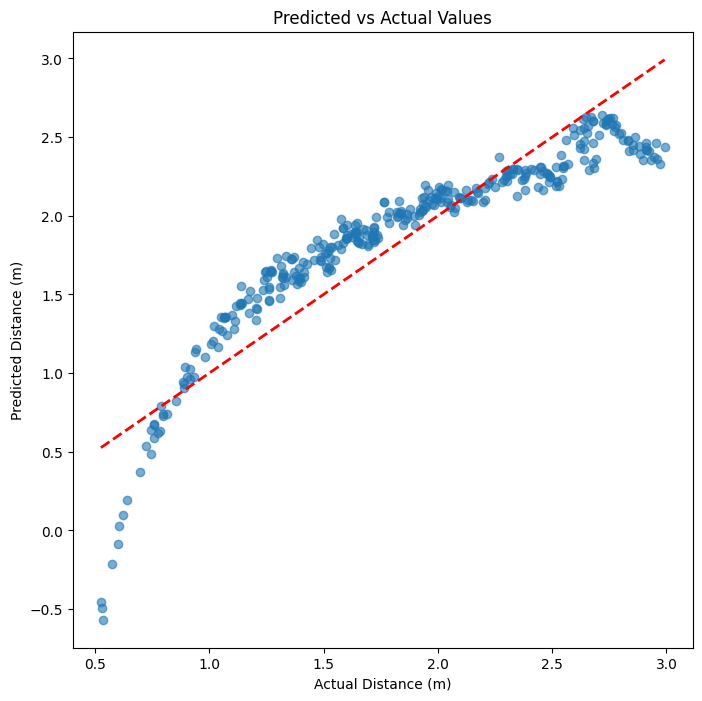

In [22]:
def plot_predicted_vs_actual(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Distance (m)')
    plt.ylabel('Predicted Distance (m)')
    plt.title('Predicted vs Actual Values')
    plt.show()

plot_predicted_vs_actual(model, X_test, y_test)

- Für kleine Werte unter 1 unterschätzt das Model die Distanz
- Bid zu eienr Distanz von 2 Überschätzt es die Distanzen
- Dann ist der Fehler und die Streuung für einen geringe Menge an Distanzen bis ca. 2.3m recht gering
- Ab ca. 2.3m fängt das Model an die Werte wieder zu unterschätzen
- Fehler vor allem an den Rändern

## 9. Manueller Modeltest
Die folgende function nimmt ein Bild entgegen und prüft, ob sich ein Sportsball auf dem Bild befindet. Wenn dem so ist, gibt sie die prediction results bezüglich der Entfernung des regression models aus.

In [23]:
def predict_distance_from_image(yolo_model, regression_model, image_path):
    results = yolo_model(image_path, verbose=False)
    boxes = results[0].boxes
    
    if boxes is None or len(boxes) == 0:
        return "Nichts erkannt"
    
    detected_classes = boxes.cls.tolist()
    sportsball_indices = [i for i, cls in enumerate(detected_classes) if cls == 32]
    
    if not sportsball_indices:
        return "Kein Sportsball erkannt"
    
    predictions = []
    
    for idx in sportsball_indices:
        bbox = boxes.xyxy[idx].tolist()
        upperleft_x, upperleft_y, lowerright_x, lowerright_y = bbox
        features = [[upperleft_x, upperleft_y, lowerright_x, lowerright_y]]
        predicted_distance = regression_model.predict(features)[0][0]
        
        predictions.append({
            'bbox': bbox,
            'predicted_distance': predicted_distance
        })
    
    return predictions

Die Folgende Funktion dient der Visualisierung der Prediction der Distanz des Inputimages im Vergleich zur tatsächlichen Distanz des balls. Sie nutzt dafür unter anderem die vorherige Funktion.

In [24]:
def visualize_prediction(yolo_model, regression_model, image_path, annotations_path):
    predictions = predict_distance_from_image(yolo_model, regression_model, image_path)
    
    if isinstance(predictions, str):
        print(predictions)
        return
    
    image = cv2.imread(image_path)
    image_name = os.path.basename(image_path)
    df = pd.read_csv(annotations_path)
    row = df[df['ImageName'] == image_name]
    actual_distance = row.iloc[0]['Distance'] if not row.empty else None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image_rgb)
    
    for i, pred in enumerate(predictions):
        bbox = pred['bbox']
        distance = pred['predicted_distance']
        
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        
        rect = patches.Rectangle((x1, y1), width, height, 
                               linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        label = f"Ball {i+1}:\nPredcited: {distance:.2f}m\nActual: {actual_distance}m"
        ax.text(x1, y1-10, label, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7),
               fontsize=10, color='black', weight='bold')
    
    ax.set_title(f"Tennisball Distanzschätzung\nGefunden: {len(predictions)} Ball(s)", 
                fontsize=14, weight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return predictions

c:\Users\Lenovo\Documents\Repositories\KI_und_Big_Data_Projekt_SoSe25\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


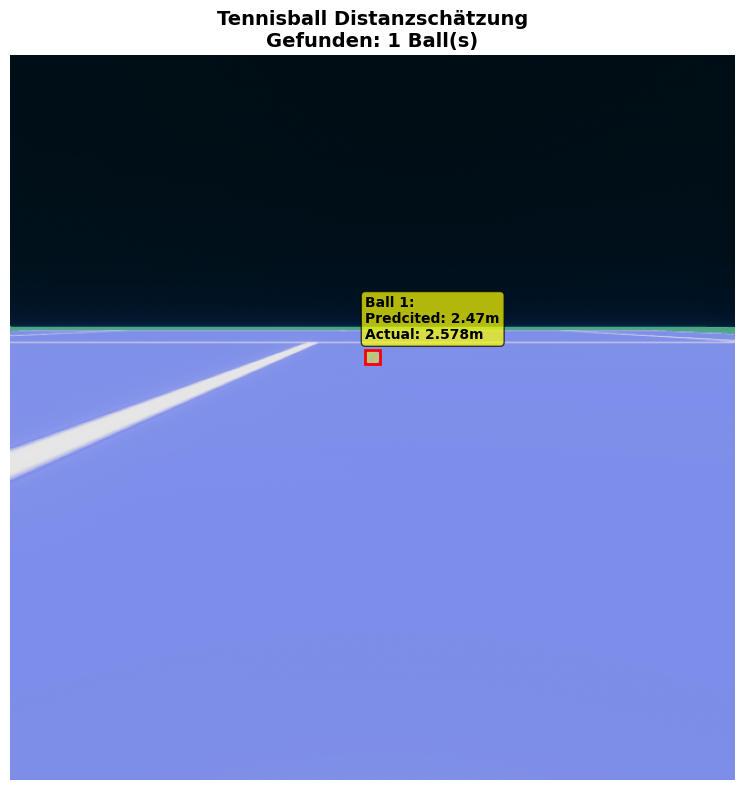

[{'bbox': [313.44561767578125,
   260.1419982910156,
   326.01190185546875,
   272.2564392089844],
  'predicted_distance': np.float64(2.4660805579259986)}]

In [25]:
yolo_model = YOLO('yolov8n.pt')
distance_model = model  

test_image_path = "C:/Users/Lenovo/Documents/Repositories/KI_und_Big_Data_Projekt_SoSe25/data/0_test_image/2025-07-05_15-54-29_Screenshot_0.png"
test_csv_path = "C:/Users/Lenovo/Documents/Repositories/KI_und_Big_Data_Projekt_SoSe25/data/0_test_image/annotations.csv"

visualize_prediction(yolo_model, distance_model, test_image_path, test_csv_path)

Interessant zu sehen dass entsprechend des Actual vs Predicted Plots der Vorhergesagte Wert hier tatsächlich unterschätzt wird.

### Test mit einem Bild, auf dem nichts erkannt werden konnte

In [26]:
eins = "C:/Users/Lenovo/Documents/Repositories/KI_und_Big_Data_Projekt_SoSe25/data/1_test_2/2025-07-05_16-36-34_Screenshot_0.png"
zwei = "C:/Users/Lenovo/Documents/Repositories/KI_und_Big_Data_Projekt_SoSe25/data/1_test_2/annotations.csv"

predictions = predict_distance_from_image(yolo_model, distance_model, eins)
print("Vorhersagen:", predictions)

visualize_prediction(yolo_model, distance_model, eins, zwei)

Vorhersagen: Kein Sportsball erkannt
Kein Sportsball erkannt


## 10. Test eines Polynomialen Models

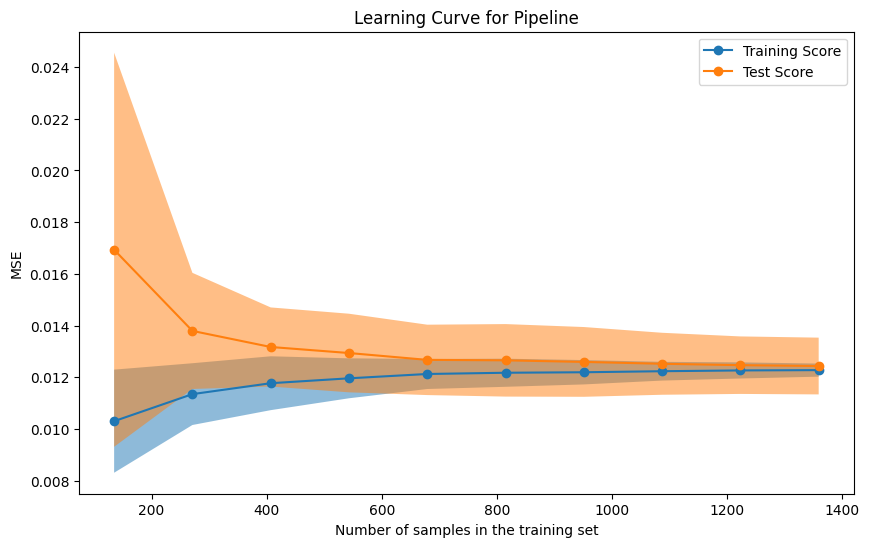

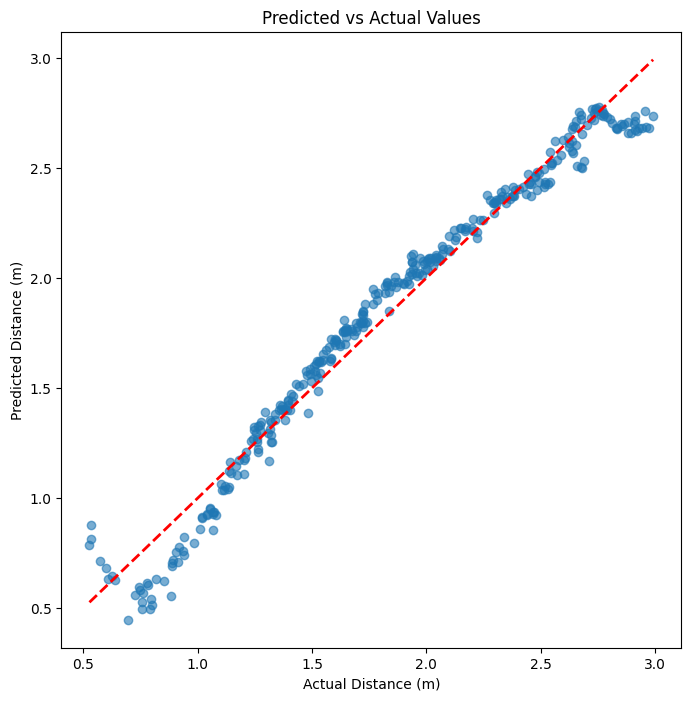

In [27]:
polynomial_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('linear', linear_model.LinearRegression())
])

polynomial_model.fit(X_train, y_train)

plot_learningCurveDisplay(polynomial_model, X, y)
plot_predicted_vs_actual(polynomial_model, X_test, y_test)

Zu sehen ist, dass sich die learning Curve nur etwas verändert hat, aber die Konvergenz definitiv noch drastischer geworden ist. Auch der Vergleich der vorhergesagten vs tatsächlichen Werte hat sich drsatisch verbessert. Dennoch bleibt das Model an den Rändern verbesserungswürdig.

In [28]:
y_prediction = polynomial_model.predict(X_test)
mse = mean_squared_error(y_test, y_prediction)
print('Feature Names:', "upperleft_x", "upperleft_y", "lowerright_x", "lowerright_y")
print('Coefficients:', model.coef_) 
print('Mean squared error (MSE):', mse) 
print("Root mean squared error (RMSE):", np.sqrt(mse))  
print('Coefficient of determination (R2):', r2_score(y_test, y_prediction))


Feature Names: upperleft_x upperleft_y lowerright_x lowerright_y
Coefficients: [[ -0.0027227    0.078482    -0.15628   -0.046599]]
Mean squared error (MSE): 0.012061470623967906
Root mean squared error (RMSE): 0.10982472683311308
Coefficient of determination (R2): 0.9701794198289172


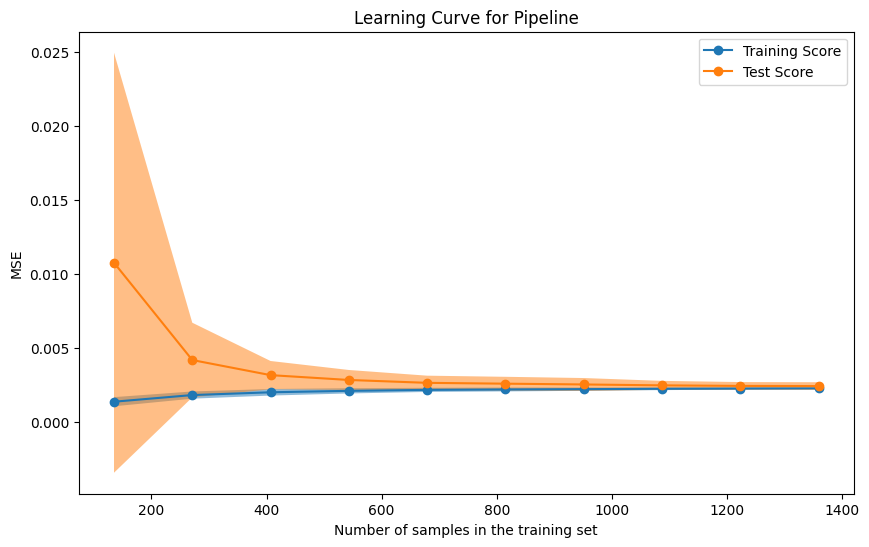

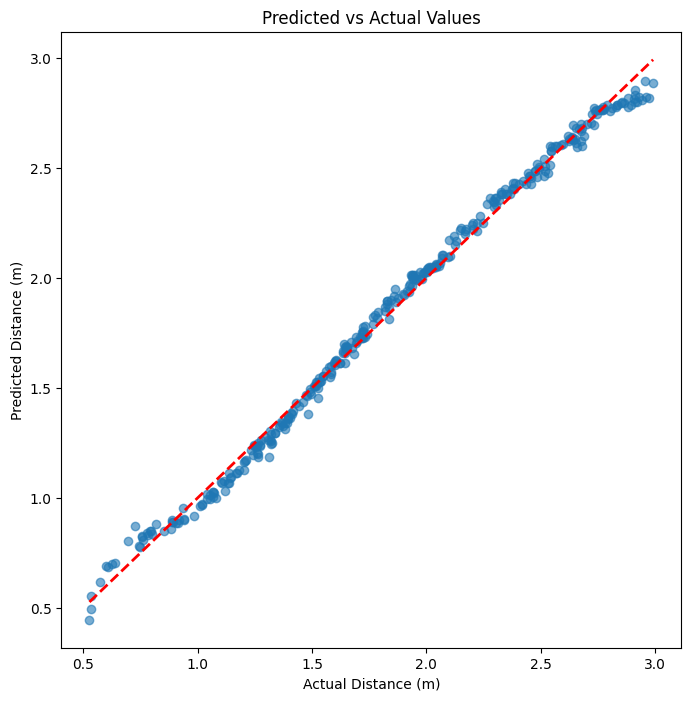

In [29]:
polynomial_model = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('linear', linear_model.LinearRegression())
])

polynomial_model.fit(X_train, y_train)

plot_learningCurveDisplay(polynomial_model, X, y)
plot_predicted_vs_actual(polynomial_model, X_test, y_test)

In [30]:
y_prediction = polynomial_model.predict(X_test)
mse = mean_squared_error(y_test, y_prediction)
print('Feature Names:', "upperleft_x", "upperleft_y", "lowerright_x", "lowerright_y")
print('Coefficients:', model.coef_) 
print('Mean squared error (MSE):', mse) 
print("Root mean squared error (RMSE):", np.sqrt(mse))  
print('Coefficient of determination (R2):', r2_score(y_test, y_prediction))

Feature Names: upperleft_x upperleft_y lowerright_x lowerright_y
Coefficients: [[ -0.0027227    0.078482    -0.15628   -0.046599]]
Mean squared error (MSE): 0.002177809479067266
Root mean squared error (RMSE): 0.046667006322103695
Coefficient of determination (R2): 0.9946156199196127


c:\Users\Lenovo\Documents\Repositories\KI_und_Big_Data_Projekt_SoSe25\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


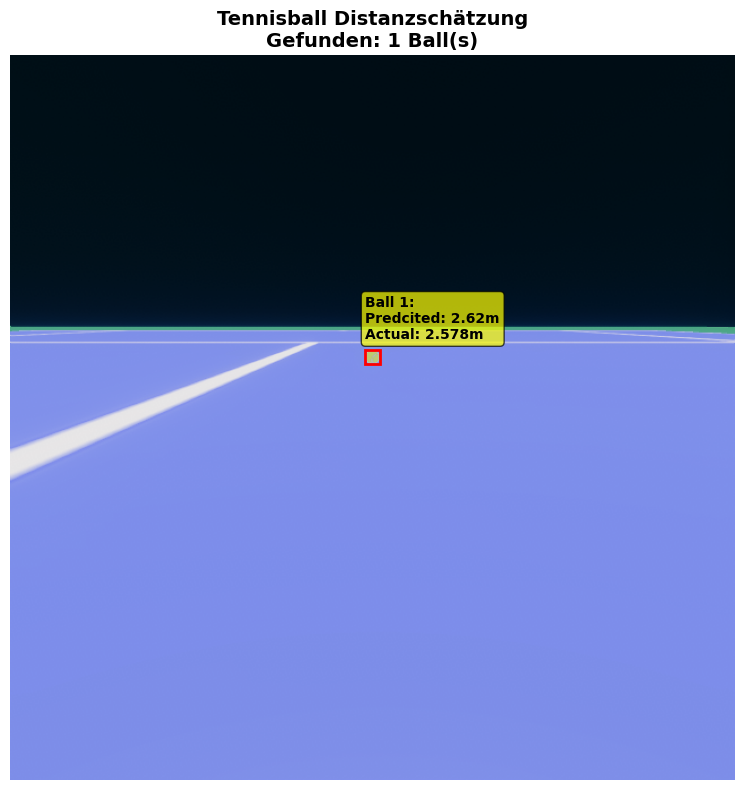

[{'bbox': [313.44561767578125,
   260.1419982910156,
   326.01190185546875,
   272.2564392089844],
  'predicted_distance': np.float64(2.618486916158872)}]

In [31]:
distance_model = polynomial_model
visualize_prediction(yolo_model, distance_model, test_image_path, test_csv_path)

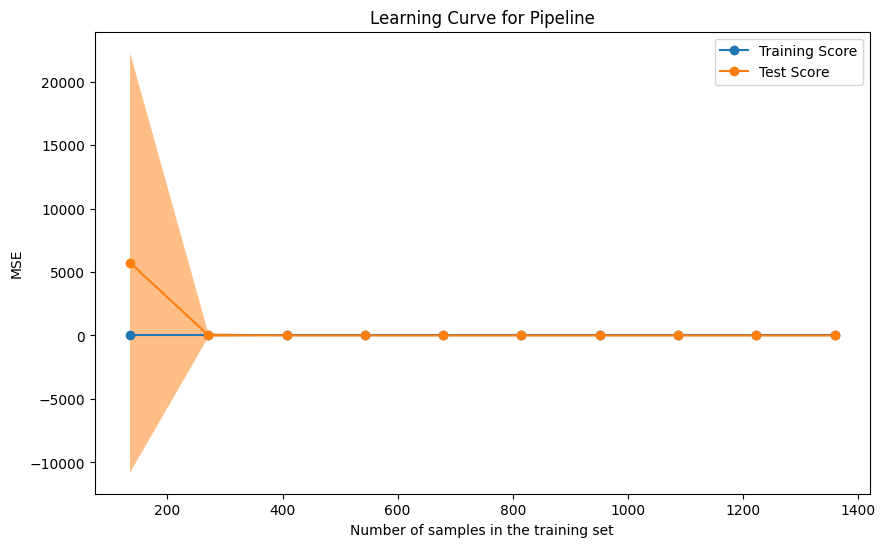

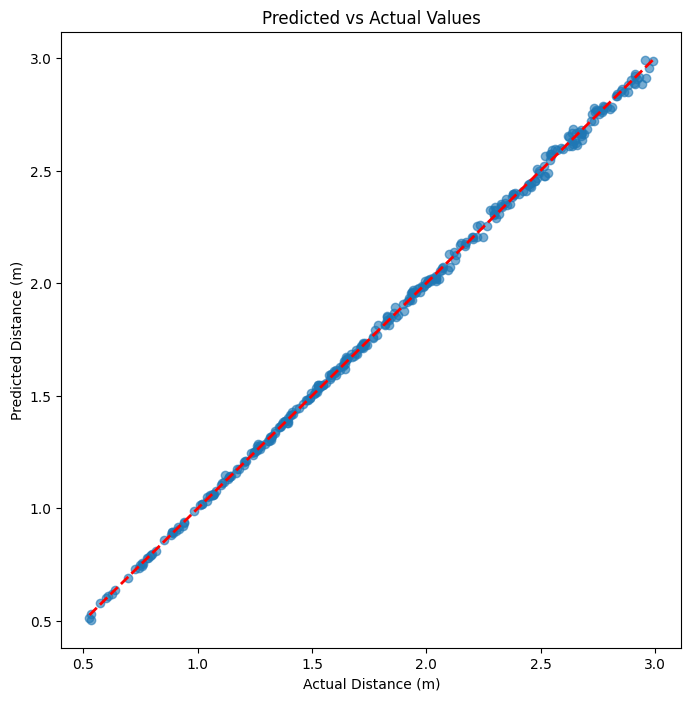

In [32]:
polynomial_model = Pipeline([
    ('poly', PolynomialFeatures(degree=10)),
    ('linear', linear_model.LinearRegression())
])

polynomial_model.fit(X_train, y_train)

plot_learningCurveDisplay(polynomial_model, X, y)
plot_predicted_vs_actual(polynomial_model, X_test, y_test)

Bei einem Polynom zehntes Grades tritt eine nahezu perfekte Konvergenz auf; beide Kurven stabilisieren sich weiter, je größer die Anzahl der Samples und es gibt keine Schwankungen oder Unterschiede bei eienr größeren Anzahl von Samples. Allerdings ist auch klar erkennbar, dass hier mehr als ca. 300 Sample keinen wirklichen Merhwert für dass Model bieten.

In [33]:
y_prediction = polynomial_model.predict(X_test)
mse = mean_squared_error(y_test, y_prediction)
print('Feature Names:', "upperleft_x", "upperleft_y", "lowerright_x", "lowerright_y")
print('Coefficients:', model.coef_) 
print('Mean squared error (MSE):', mse) 
print("Root mean squared error (RMSE):", np.sqrt(mse))  
print('Coefficient of determination (R2):', r2_score(y_test, y_prediction))

Feature Names: upperleft_x upperleft_y lowerright_x lowerright_y
Coefficients: [[ -0.0027227    0.078482    -0.15628   -0.046599]]
Mean squared error (MSE): 0.0002732298376286256
Root mean squared error (RMSE): 0.016529665381629043
Coefficient of determination (R2): 0.9993244710755299


In [36]:
print("Wertebereiche:")
for col in ['upperleft_x', 'upperleft_y', 'lowerright_x', 'lowerright_y']:
    print(f"{col}: {X[col].min():.1f} - {X[col].max():.1f}")

Wertebereiche:
upperleft_x: 288.2 - 314.6
upperleft_y: 256.1 - 363.4
lowerright_x: 325.3 - 352.3
lowerright_y: 266.9 - 428.5


Interessant zu sehen ist, dass die Koeffizienten über alle Modell hinweg immer gleich bleiben.
Auffällig ist, dass upperleft_y dabei immer den größten Wert hat, also theoretisch den größten Einfluss, allerdings kann kein direkter Vergleich der Koeffizienten vorgenommen werden, da die Bounding Box Koordinaten unterschiedliche Wertebereiche haben. Für eine korrekte Interpretation müsste ich die Werte erst einmal standardisieren.

c:\Users\Lenovo\Documents\Repositories\KI_und_Big_Data_Projekt_SoSe25\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


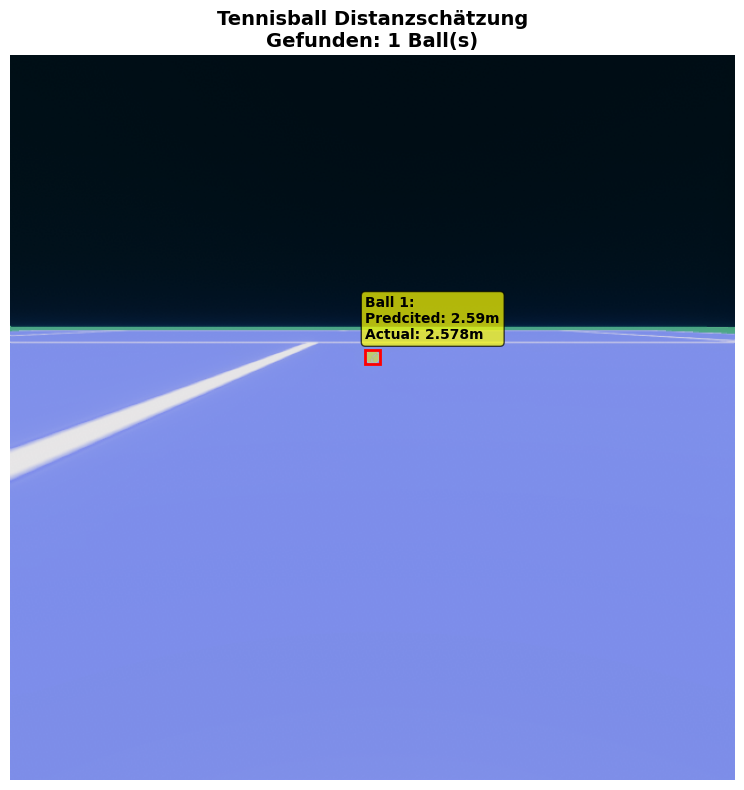

[{'bbox': [313.44561767578125,
   260.1419982910156,
   326.01190185546875,
   272.2564392089844],
  'predicted_distance': np.float64(2.5933955987183737)}]

In [34]:
distance_model = polynomial_model
visualize_prediction(yolo_model, distance_model, test_image_path, test_csv_path)